## Import Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#package DL
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

#package DL arsitektur(layer)
from jcopdl.layers import linear_block

#package DL data preparation
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#progressbar
from tqdm.auto import tqdm

#cek cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset dan Dataloader

In [2]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [3]:
#cek
loader = iter(trainloader)
images, labels = next(loader)
images.shape

torch.Size([128, 1, 28, 28])

In [4]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

### Visualize Data

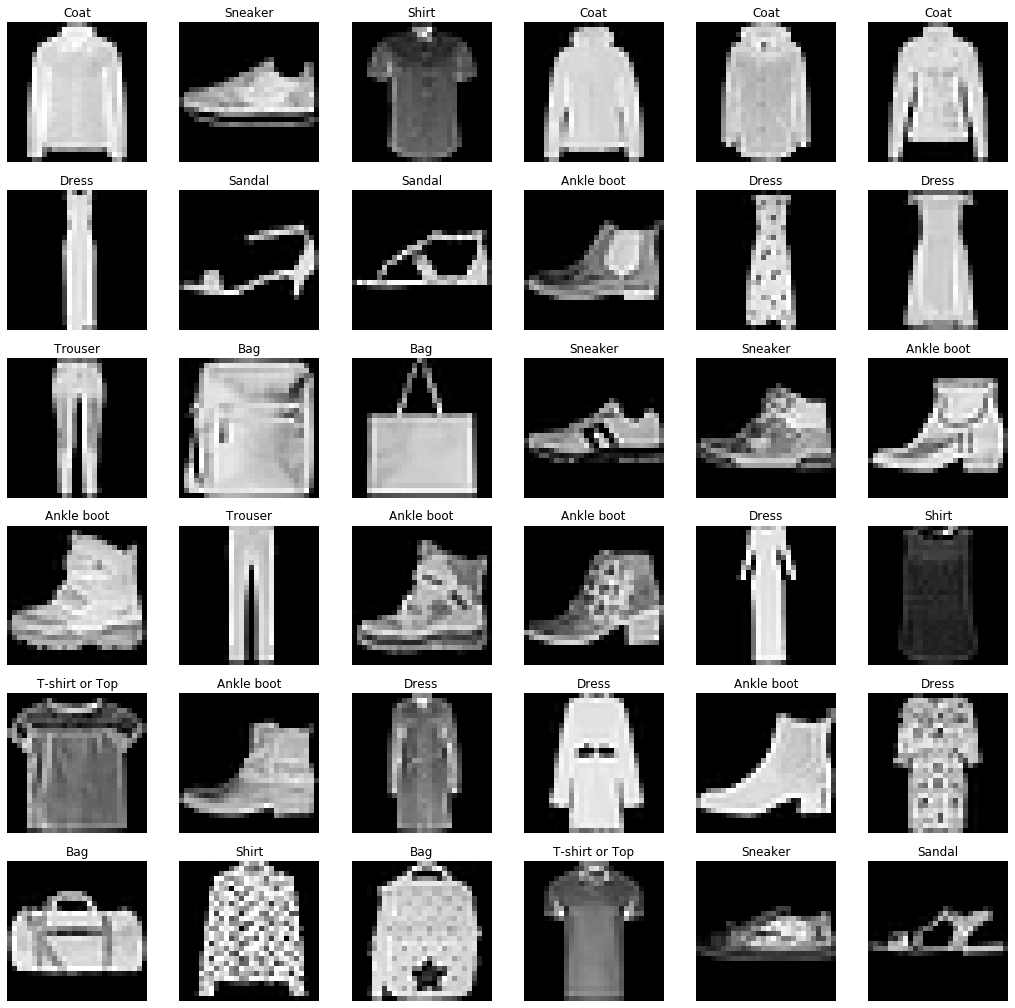

In [5]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img.view(28,28).cpu(), cmap='gray')
    label = label2cat[label.item()]
    ax.set_title(f"{label}")
    ax.axis('off');

## Arsitektur dan Config

In [7]:
class NN(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout1, dropout2):
        super().__init__()
        
        self.fc = nn.Sequential(
        nn.Flatten(),
        linear_block(input_size, n1, activation="relu", dropout=dropout1),
        linear_block(n1, n2, activation="relu", dropout=dropout2),
        linear_block(n2, output_size, activation="lsoftmax")    
        )
        
    def forward(self, x):
        return self.fc(x)

In [8]:
config = set_config({
    
    "input_size" : 784,
    "n1" : 512,
    "n2" : 128,
    "output_size" : 10,
    "dropout1" : 0.25,
    "dropout2" : 0.25,
    "author" : "Ridho Alhafizhi",
    "batch_size": bs
    
})

## Training Preparation (MCOC)

In [9]:
model = NN(config.input_size, config.n1, config.n2, config.output_size, config.dropout1, config.dropout2).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model-ujian", plot_every=5, early_stop_patience=5 )

In [10]:
model

NN(
  (fc): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
      (1): LogSoftmax()
    )
  )
)

## Training

In [ ]:
#Training
while True: 
    model.train()

    cost = 0 
    correct = 0 
    
    for images, labels in tqdm(trainloader, desc='<< Training >> '): 
        images, labels = images.to(device), labels.to(device) 
        
        output = model(images) 
        loss = criterion(output, labels) 
        loss.backward()

        optimizer.step() 
        optimizer.zero_grad()
        
        cost += loss.item() *images.shape[0] 
        correct += (output.argmax(1) == labels).sum().item() 

    train_cost = cost / len(train_set)
    train_score = correct / len(train_set) 

    #Testing
    with torch.no_grad(): 
        model.eval()
            
        cost = 0 
        correct = 0 
            
        for images, labels in tqdm(testloader, desc='<< Testing >> '):
            images, labels = images.to(device), labels.to(device) 
        
            output = model(images) 
            loss = criterion(output,labels) 

            cost += loss.item() *images.shape[0] 
            correct += (output.argmax(1) == labels).sum().item() 

    test_cost = cost / len(test_set)
    test_score = correct / len(test_set) 
      
            
    # Callback
    # Logging and Reporting 
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint #sesuai default diatas, save stiap 50 epoch
    callback.save_checkpoint() 

    # Runtime Plotting #setiap 5 epoch di plot
    callback.cost_runtime_plotting() 
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break